## Process data and generates embedding vectors

In [1]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install the sentence-transformers package
!pip install sentence-transformers

In [125]:
# Adding the helper and models directory to sys.path for module import
import sys
sys.path.append('/content/drive/MyDrive/ShallowMinds/helper/')
sys.path.append('/content/drive/MyDrive/ShallowMinds/models/')

In [4]:
# Importing the required modules
import dataProcessor
import generateEmbedding
import torch
from sklearn import metrics

In [5]:
# Creating an instance of the dataProcessor class and processing the data
data_processor = dataProcessor.DataProcessor('/content/drive/MyDrive/ShallowMinds/data/roft.csv')
data_dict = data_processor.process_data()

In [30]:
# Creating an instance of the SentenceEmbedder class and generating embeddings for train, validation, and test sets
sentence_embedder = generateEmbedding.SentenceEmbedder()
train_X = sentence_embedder.generate_embeddings(data_dict['train']['X'])
val_X = sentence_embedder.generate_embeddings(data_dict['val']['X'])
test_X = sentence_embedder.generate_embeddings(data_dict['test']['X'])

100%|██████████| 914/914 [01:18<00:00, 11.57it/s]


In [31]:
# Creating one-hot vectors for the output variable for train, validation, and test sets
train_Y, val_Y, test_Y = sentence_embedder.onehot_output(data_dict['train']['Y'], data_dict['val']['Y'], data_dict['test']['Y'])

## Single Layer Attention Model

In [126]:
import SingleAttentionClassifier

# Creating an instance of the AttentionClassifier class for classification
AttentionModel = SingleAttentionClassifier.AttentionClassifier(input_size=768, hidden_size=64, num_classes=10)

# Defining the optimizer for training the model
optimizer = torch.optim.Adam(AttentionModel.parameters(), lr=1e-4, weight_decay=1e-5)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')


# Creating an instance of the Trainer class and training the model
trainer = SingleAttentionClassifier.Trainer(AttentionModel, optimizer, 0.005)
trainer.train(train_X, train_Y, val_X, val_Y, num_epochs=100, batch_size=10)

Epoch 1/100: train_loss=2.3680 train_acc=0.1323
Validation accuracy: 0.1127
Epoch 2/100: train_loss=2.3043 train_acc=0.1542
Validation accuracy: 0.1302
Epoch 3/100: train_loss=2.2669 train_acc=0.1819
Validation accuracy: 0.1575
Epoch 4/100: train_loss=2.2370 train_acc=0.2126
Validation accuracy: 0.1816
Epoch 5/100: train_loss=2.2096 train_acc=0.2354
Validation accuracy: 0.1958
Epoch 6/100: train_loss=2.1872 train_acc=0.2532
Validation accuracy: 0.2057
Epoch 7/100: train_loss=2.1698 train_acc=0.2692
Validation accuracy: 0.2177
Epoch 8/100: train_loss=2.1558 train_acc=0.2818
Validation accuracy: 0.2243
Epoch 9/100: train_loss=2.1439 train_acc=0.2905
Validation accuracy: 0.2341
Epoch 10/100: train_loss=2.1335 train_acc=0.2959
Validation accuracy: 0.2407
Epoch 11/100: train_loss=2.1243 train_acc=0.3038
Validation accuracy: 0.2429
Epoch 12/100: train_loss=2.1159 train_acc=0.3069
Validation accuracy: 0.2352
Epoch 13/100: train_loss=2.1084 train_acc=0.3095
Validation accuracy: 0.2396
Epoch 14

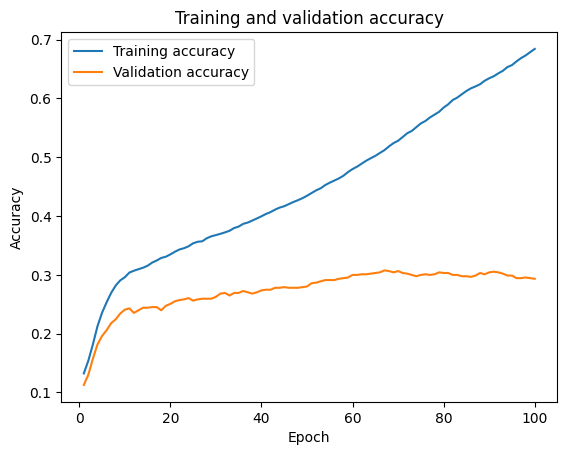

In [128]:
import matplotlib.pyplot as plt

train_acc = trainer.train_acc_history # example values
val_acc = trainer.val_acc_history # example values
epochs = range(1, 101)

plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [55]:
import torch
from torchsummary import summary

model = ... # your PyTorch model
summary(AttentionModel, input_size=(10, 768)) # input_size is the expected size of your input tensor

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 64]          49,216
            Linear-2                [-1, 10, 1]              65
SingleLayerAttention-3                  [-1, 640]               0
            Linear-4                   [-1, 10]           6,410
Total params: 55,691
Trainable params: 55,691
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.01
Params size (MB): 0.21
Estimated Total Size (MB): 0.25
----------------------------------------------------------------


In [ ]:
# Predicting the output for train,test and validation set and calculating the accuracy
prediction = AttentionModel(torch.Tensor(train_X).to(trainer.device)).argmax(dim=1).cpu().detach().numpy()
print(f'Train Accuracy = {metrics.accuracy_score(prediction,train_Y.argmax(dim=1)):.4f}')
prediction = AttentionModel(torch.Tensor(test_X).to(trainer.device)).argmax(dim=1).cpu().detach().numpy()
print(f'Test Accuracy = {metrics.accuracy_score(prediction,test_Y.argmax(dim=1)):.4f}')
prediction = AttentionModel(torch.Tensor(val_X).to(trainer.device)).argmax(dim=1).cpu().detach().numpy()
print(f'Validation Accuracy = {metrics.accuracy_score(prediction,val_Y.argmax(dim=1)):.4f}')

## Tree based models on cosine similarity values for consecutive embeddings

In [6]:
# Creating an instance of the SentenceEmbedder class and generating cosine similarity values 
# for consecutive embeddings for the train, validation, and test sets
sentence_embedder = generateEmbedding.SentenceEmbedder()
train_X_cosine = sentence_embedder.generate_running_embedding(data_dict['train']['X'])
val_X_cosine = sentence_embedder.generate_running_embedding(data_dict['val']['X'])
test_X_cosine = sentence_embedder.generate_running_embedding(data_dict['test']['X'])

100%|██████████| 914/914 [08:03<00:00,  1.89it/s]


In [7]:
train_Y_cosine, val_Y_cosine, test_Y_cosine = data_dict['train']['Y'], data_dict['val']['Y'], data_dict['test']['Y']

In [8]:
# Filter out data points where y is less than or equal to 0
train_X_filtered, train_Y_filtered = sentence_embedder.eliminate_zero_boundry(train_X_cosine ,train_Y_cosine)
test_X_filtered, test_Y_filtered = sentence_embedder.eliminate_zero_boundry(test_X_cosine ,test_Y_cosine)
val_X_filtered, val_Y_filtered = sentence_embedder.eliminate_zero_boundry(val_X_cosine ,val_Y_cosine)

In [98]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100,max_features = 0.9,max_samples = 0.7, max_depth = 7)
rf.fit(train_X_filtered, train_Y_filtered)
prediction = rf.predict(test_X_filtered)
print(f'Test Accuracy = {metrics.accuracy_score(prediction,test_Y_filtered):.4f}')

Test Accuracy = 0.2168


## Logistic Regression by Appending Embeddings

In [ ]:
train_X_appended = train_X.reshape(train_X.shape[0],train_X.shape[1]*train_X.shape[2])
test_X_appended  = test_X.reshape(test_X.shape[0],test_X.shape[1]*test_X.shape[2])
val_X_appended = val_X.reshape(val_X.shape[0],val_X.shape[1]*val_X.shape[2])

In [ ]:
train_Y_appended, val_Y_appended, test_Y_appended = data_dict['train']['Y'], data_dict['val']['Y'], data_dict['test']['Y']

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

scaler = StandardScaler()  
scaler.fit(train_X_appended)
X_train_scaled = scaler.transform(train_X_appended)  
X_test_scaled = scaler.transform(test_X_appended)
X_val_scaled = scaler.transform(val_X_appended)

lr = linear_model.LogisticRegression(
  penalty='l2',
  random_state=42069,
  multi_class='multinomial',
  max_iter = 200,
  fit_intercept = False,
)

lr.fit(X_train_scaled,train_Y_appended)
acc = metrics.accuracy_score(lr.predict(X_test_scaled),test_Y_appended)
print("Test accuracy: " + str(acc))

In [ ]:
print("Validation accuracy: " + str(metrics.accuracy_score(lr.predict(X_val_scaled),val_Y_appended)))

Validation accuracy: 0.2425595238095238


In [ ]:
print("Train accuracy: " + str(metrics.accuracy_score(lr.predict(X_train_scaled),train_Y_appended)))

Train accuracy: 1.0


# Majority Class

In [117]:
from collections import Counter

y = []
for vector in test_Y:
    index = torch.argmax(vector)
    integer = index.item()
    y.append(integer)

counter = Counter(y)
pred = [counter.most_common(1)[0][0]]*len(y)

print("Test accuracy: " + str(metrics.accuracy_score(y,pred)))

Test accuracy: 0.14770240700218817


# Random Class

In [118]:
import random

y = []
for vector in test_Y:
    index = torch.argmax(vector)
    integer = index.item()
    y.append(integer)

pred = [random.randint(0, 9) for _ in range(len(y))]

print("Test accuracy: " + str(metrics.accuracy_score(y,pred)))

Test accuracy: 0.10175054704595186
